In [ ]:
Discount factor

Discount factor - это параметр, используемый в теории управления и обучении с подкреплением для оценки стоимости будущих вознаграждений. Он обозначается символом γ (гамма).

В контексте задачи обучения с подкреплением, такой как у DQN алгоритма, фактор дисконтирования применяется к будущим вознаграждениям, чтобы учесть уменьшение их значения с течением времени. Фактор дисконтирования позволяет агенту принимать во внимание не только мгновенные вознаграждения, но и будущие вознаграждения, приводя к более долгосрочной стратегии.

Формула для дисконтирования будущих вознаграждений выглядит следующим образом:

Gt = Rt+1 + γ Rt+2 + γ^2 Rt+3 + … = ∑∞k=0 γ^k Rt+k+1

где:

    Gt - дисконтированная сумма вознаграждений (вознаграждение с учетом будущих шагов);
    Rt+k+1 - вознаграждение, полученное на шаге t+k+1;
    γ - фактор дисконтирования, 0≤γ≤1.

Фактор дисконтирования имеет важное значение при принятии решений в условиях неопределенности, где агенту нужно учитывать как мгновенные, так и будущие вознаграждения, с учетом их временного удаления. Выбор подходящего значения для фактора дисконтирования может влиять на стратегии обучения.
Long-term и Short-term стратегия

Фактор дисконтирования оказывает сильное влияние на долгосрочность стратегии. В контексте обучения с подкреплением и стратегий агента, термины "краткосрочные" и "долгосрочные" относятся к временным характеристикам принятия решений агентом.

Краткосрочные стратегии:

    Агент, придерживающийся краткосрочной стратегии, ориентируется в основном на текущую информацию и мгновенные вознаграждения. Такой агент может принимать решения, которые приносят максимальное мгновенное вознаграждение, не уделяя большого внимания будущим шагам. Такой агент может принимать решения, которые приносят максимальное мгновенное вознаграждение, не уделяя большого внимания будущим шагам.

Долгосрочные стратегии:

    Агент, придерживающийся долгосрочной стратегии, учитывает будущие вознаграждения и последствия своих действий на протяжении более длительного времени. Такой агент может предпочесть действия, которые могут не приносить максимальное мгновенное вознаграждение, но могут способствовать достижению более высоких наград в будущем.

Когда говорят о краткосрочных или долгосрочных стратегиях в контексте обучения с подкреплением, обычно имеется в виду, как агент принимает решения, оптимизируя сумму будущих вознаграждений. Фактор дисконтирования γ в уравнении обучения с подкреплением регулирует степень учета будущих вознаграждений, и, таким образом, влияет на то, насколько агент ориентирован на краткосрочные или долгосрочные перспективы.


In [ ]:
Метрики для оценки модели

В данной работе мы рассмотрим некоторые метрики, которые могут быть использованы для оценки обучения модели. Аналогично первой лабораторной работы мы будем решать задачу в окружении CartPole-v1, а в качестве модели используем уже знакомый DQN. При этом мы обучим модель несколько разных с разным параметром Discount factor.

Для оценки модели мы рассмотрим следущие метрики:

    Q-values, их поведение и сходимость.
    Средняя награда за эпизод.
    Время затрачиваемое на обучение модели.


In [ ]:
Установка зависимостей

На первом шаге мы начинаем с установки необходимых библиотек. Пакет gymnasium предоставляет различные среды для обучения с подкреплением, в то время как stable-baselines3 предоставляет реализации различных алгоритмов обучения с подкреплением.

In [ ]:
# Установка необходимых библиотек
!pip install gymnasium
!pip install stable-baselines3

In [ ]:
# Импортируем пакет, которые будут использованы в данной работе

In [1]:
import torch as th
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import time

In [ ]:
Q-значения (Q-values) представляют собой оценки или оценочные функции, используемые в контексте обучения с подкреплением для измерения ожидаемой полезности (ценности) принятия определенного действия в конкретном состоянии.

Для получения значений для нашей модели реализуем функцию, которая их извлекает из q-сети.

In [2]:
def q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
  # Доступ к Q-network
  q_net = model.q_net

  # Конвертируем observation в PyTorch tensor
  obs_tensor = th.tensor(obs, dtype=th.float32)

  # Изменяем размерность
  obs_tensor = obs_tensor.unsqueeze(0)

  #Извлекаем Q-values
  q_values = model.q_net.forward(obs_tensor.cuda())

  return q_values.cpu().detach().numpy()[0]

In [ ]:

Для наглядности результатов Q-values необходимо создать функцию для составления графика по значениям.

In [3]:
def plot_q_values(q_values_list):

  # Построение графика
  plt.figure(figsize=(10, 6))
  for i in range(6):
    plt.plot(q_values_list[i], label='Q%i Values' % i)
  plt.xlabel('Time')
  plt.ylabel('Q-Values')
  plt.title('Convergence of Q-Values over Time')
  plt.legend()
  plt.show()

In [ ]:
Следующий блок кода служит для следующих целей:

    Создание окружения
    Создание модели
    Обучение модели
    Оценка модели до обучения
    Оценка модели после обучения
    Измерение времени обучени

In [12]:
def mean_reward(discount_factor):
  #Создание окружения
  env = gym.make("Taxi-v3", render_mode="rgb_array")

  #Создание модели
  model = DQN("MlpPolicy", env, verbose=1, gamma=discount_factor, learning_rate=0.001)

  #Количество эпизодов для оценки модели
  n_eval_episodes = 250

  #Оценка модели до обучения
  mean_reward, std_reward = evaluate_policy(model, gym.make("Taxi-v3", render_mode="rgb_array"), deterministic=True, n_eval_episodes=n_eval_episodes)
  print(f"До обучения модели с discount_factor = {discount_factor}, mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

  # Засекаем начальное время
  start_time = time.time()

  #Обучение модели
  model.learn(total_timesteps=10000, log_interval=100)

  # Засекаем время завершения
  end_time = time.time()

  #Оценка модели после обучения
  mean_reward, std_reward = evaluate_policy(model, gym.make("Taxi-v3", render_mode="rgb_array"), deterministic=True, n_eval_episodes=n_eval_episodes)
  print(f"После обучения модели с discount_factor = {discount_factor}, mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
  model.save(f"dqn_taxi_{discount_factor}")
  del model

  # Вычисляем время обучений
  learn_time = end_time - start_time
  return env, learn_time

In [ ]:
Изменение значения discount factor (γ) в DQN может оказать существенное воздействие на обучение агента и его стратегию.

Воздействие на краткосрочные или долгосрочные стратегии:

    При более высоком значении γ (ближе к 1) агент будет больше учитывать будущие вознаграждения, что может способствовать формированию более долгосрочных стратегий.

    При более низком значении γ (ближе к 0) агент будет более склонен к учету только мгновенных вознаграждений, что может привести к формированию краткосрочных стратегий.

Влияние на стабильность обучения:

    Высокий γ может сделать обучение более стабильным, особенно в средах с большим количеством шума или случайности.
    Низкий γ может привести к более нестабильному обучению, так как агент будет менее чувствителен к долгосрочным последствиям своих действий.

Влияние на временные рамки обучения:

    Различные значения γ могут потребовать различных временных рамок обучения для достижения оптимальных стратегий.
    Изменение γ может потребовать перенастройки гиперпараметров и количества шагов обучения.

Адаптивность к задаче:

    Эффективное значение γ может зависеть от конкретной задачи. Например, в задачах с большой неопределенностью и случайностью, более высокий γ может быть полезен.

Экспериментальные результаты:

    Чтобы определить оптимальное значение γ для вашей конкретной задачи, часто требуется провести эксперименты с различными значениями, а затем анализировать результаты.



In [13]:
def q_values_calculation(discount_factor, env):
  #Загружаем созданную и созраненную модель
  model = DQN.load(f"dqn_taxi_{discount_factor}")

  action_str = ['down', 'up', 'right', 'left', "pick up", "drop off"]
  q_values_list = []

  obs, info = env.reset()
  for _ in range(100):
      q_val = q_values(model,obs)
      q_values_list.append(q_val)
      action, _states = model.predict(obs, deterministic=True)

      print(f"Q-value состояния down={q_val[0]:.2f} up={q_val[1]:.2f} right={q_val[2]:.2f} left={q_val[3]:.2f} pick up={q_val[4]:.2f} drop off={q_val[5]:.2f}")
      print(f"Действие: {action_str[action]}")

      obs, reward, terminated, truncated, _ = env.step(int(action))

  return q_values_list

In [ ]:

Рассмотрим 3 значения discount factor

In [14]:
discount_factors = [0.01,0.5,0.99]

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.01, mean_reward:-200.00 +/- 0.00
После обучения модели с discount_factor = 0.01, mean_reward:-200.00 +/- 0.00
Q-value состояния down=0.03 up=-0.08 right=0.02 left=-0.15 pick up=-0.13 drop off=-0.04
Действие: down
Q-value состояния down=0.02 up=-0.08 right=0.02 left=-0.15 pick up=-0.12 drop off=-0.05
Действие: down
Q-value состояния down=0.03 up=-0.07 right=0.02 left=-0.15 pick up=-0.13 drop off=-0.05
Действие: down
Q-value состояния down=0.02 up=-0.08 right=0.01 left=-0.15 pick up=-0.12 drop off=-0.06
Действие: down
Q-value состояния down=0.02 up=-0.08 right=0.01 left=-0.15 pick up=-0.12 drop off=-0.06
Действие: down
Q-value состояния down=0.02 up=-0.08 right=0.01 left=-0.15 pick up=-0.12 drop off=-0.06
Действие: down
Q-value состояния down=0.02 up=-0.08 right=0.01 left=-0.15 pick up=-0.12 drop off=-0.06
Действие: down
Q-value состояния down=0.02 up=-0

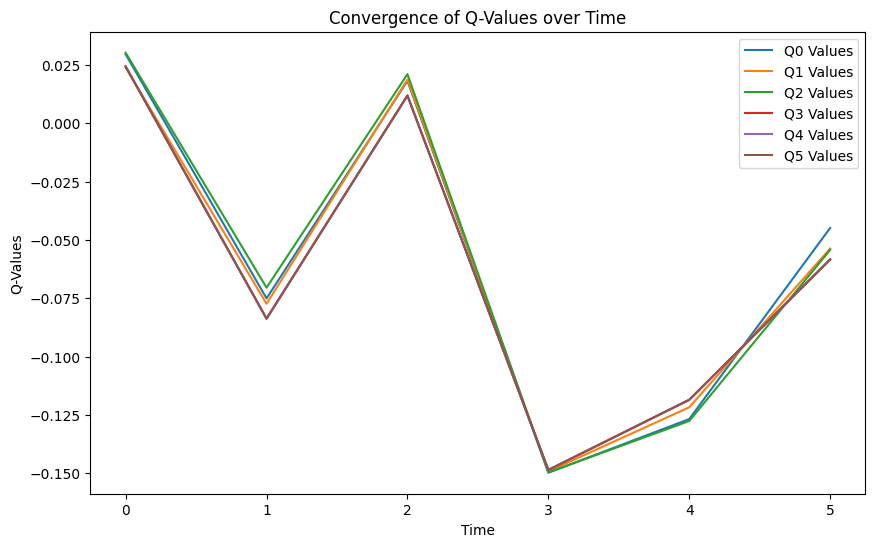

Время обучения модели при discount_factor = 0.01 : 0.40903306007385254 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.5, mean_reward:-200.00 +/- 0.00
После обучения модели с discount_factor = 0.5, mean_reward:-200.00 +/- 0.00
Q-value состояния down=-0.05 up=-0.10 right=0.01 left=0.12 pick up=-0.09 drop off=0.03
Действие: left
Q-value состояния down=-0.06 up=-0.12 right=0.01 left=0.12 pick up=-0.09 drop off=0.03
Действие: left
Q-value состояния down=-0.06 up=-0.12 right=0.01 left=0.12 pick up=-0.09 drop off=0.03
Действие: left
Q-value состояния down=-0.06 up=-0.12 right=0.01 left=0.12 pick up=-0.09 drop off=0.03
Действие: left
Q-value состояния down=-0.06 up=-0.12 right=0.01 left=0.12 pick up=-0.09 drop off=0.03
Действие: left
Q-value состояния down=-0.06 up=-0.12 right=0.01 left=0.12 pick up=-0.09 drop off=0.03
Действие: left
Q-value состояния down=-0.06 up=-0.12 right=0.01 left=0.12 pick u

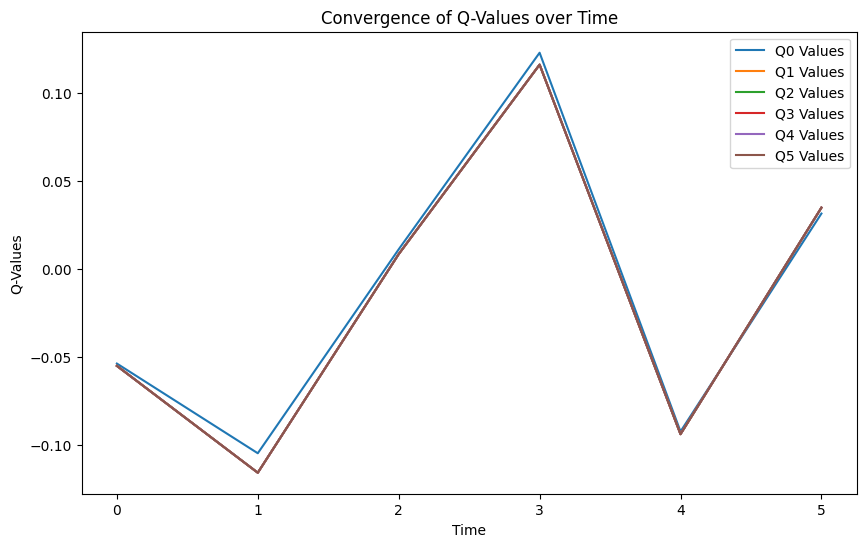

Время обучения модели при discount_factor = 0.5 : 0.39803457260131836 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.99, mean_reward:-1357.36 +/- 860.51
После обучения модели с discount_factor = 0.99, mean_reward:-1350.13 +/- 862.61
Q-value состояния down=0.07 up=0.02 right=0.08 left=-0.03 pick up=0.08 drop off=-0.06
Действие: right
Q-value состояния down=0.06 up=0.02 right=0.09 left=-0.03 pick up=0.08 drop off=-0.06
Действие: right
Q-value состояния down=0.06 up=0.02 right=0.09 left=-0.03 pick up=0.08 drop off=-0.06
Действие: right
Q-value состояния down=0.06 up=0.02 right=0.09 left=-0.03 pick up=0.08 drop off=-0.06
Действие: right
Q-value состояния down=0.06 up=0.02 right=0.09 left=-0.03 pick up=0.08 drop off=-0.06
Действие: right
Q-value состояния down=0.06 up=0.02 right=0.09 left=-0.03 pick up=0.08 drop off=-0.06
Действие: right
Q-value состояния down=0.06 up=0.02 right=0.09 left=-0.03 

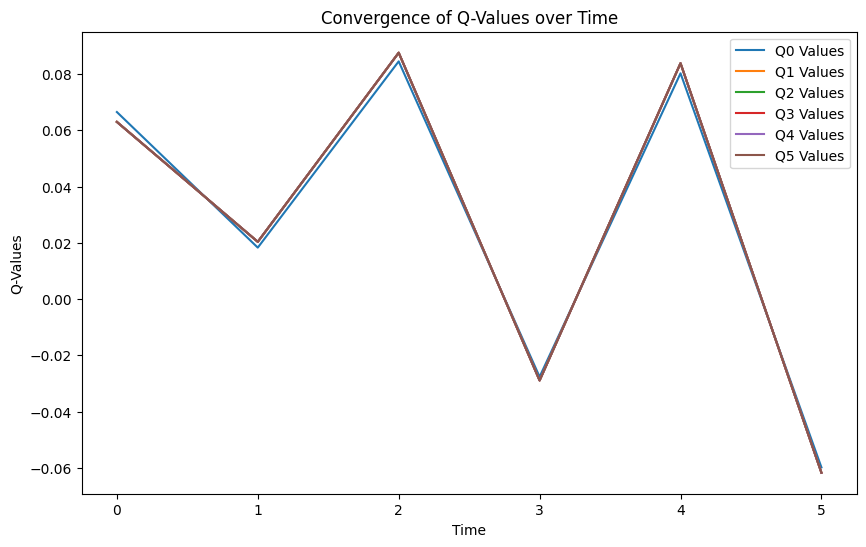

Время обучения модели при discount_factor = 0.99 : 0.3950636386871338 секунд.


In [15]:
for discount_factor in discount_factors:
  environment, time_to_lrn = mean_reward(discount_factor)
  q_vals = q_values_calculation(discount_factor, environment)
  plot_q_values(q_vals)
  print(f'Время обучения модели при discount_factor = {discount_factor} : {time_to_lrn} секунд.')

In [ ]:
# Закрытие среды
environment.close()